# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
#Import all the required libraries
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [2]:
import pandas as pd
import numpy as np
import os
import random
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


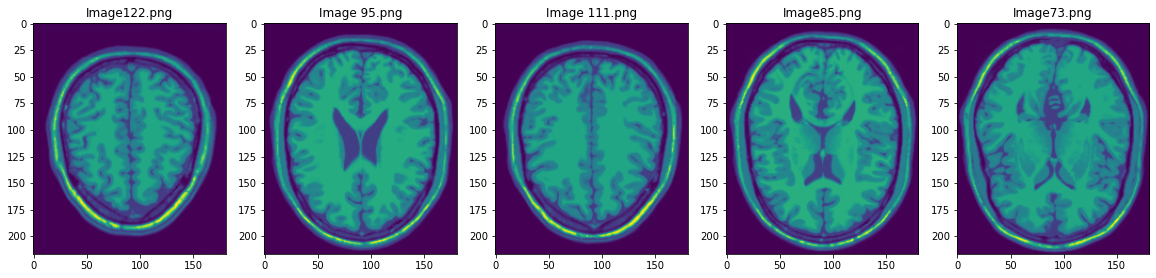

In [4]:
plt.figure(figsize=(20,20))
img_folder=r'../input/stylegands/modifieddataset/Tr1/TrainT1/'
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1
    return image

In [6]:
def process_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [7]:
def load2(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image, channels=OUTPUT_CHANNELS)
  return tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

In [8]:
train_dataset = tf.data.Dataset.list_files(r'../input/stylegands/modifieddataset/Tr1/TrainT1/*.png')
train_dataset = train_dataset.map(load2,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#train_dataset = train_dataset.shuffle(BUFFER_SIZE)
#train_dataset = train_dataset.batch(BATCH_SIZE)
for image in train_dataset.take(1):
    print("\nImage shape: ", image.numpy().shape)



Image shape:  (256, 256, 1)


In [9]:
train_dataset.element_spec

TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)

In [10]:
test_dataset = tf.data.Dataset.list_files(r'../input/stylegands/modifieddataset/Tr2/TrainT2/*.png')
test_dataset = test_dataset.map(load2,num_parallel_calls=tf.data.experimental.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE)
for image in test_dataset.take(1):
    print("\nImage shape: ", image.numpy().shape)


Image shape:  (256, 256, 1)


In [11]:
train_dataset

<ParallelMapDataset shapes: (256, 256, 1), types: tf.float32>

In [12]:
test_dataset

<ParallelMapDataset shapes: (256, 256, 1), types: tf.float32>

In [13]:
# process both classes of MRI images

In [14]:
## Image Processing 
#1.Create a function to process your images with normalisation

#2.Apply the function to both the datasets 

#3.Visualise the MRI images after processing

In [15]:
def process_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [16]:
train_dataset = train_dataset.map(
    process_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_dataset = test_dataset.map(
    process_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [17]:
sample_tr1 = next(iter(train_dataset))
sample_tr2 = next(iter(test_dataset))

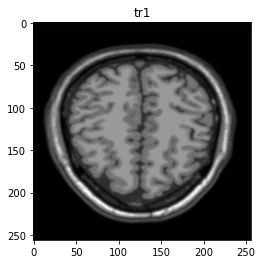

In [18]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

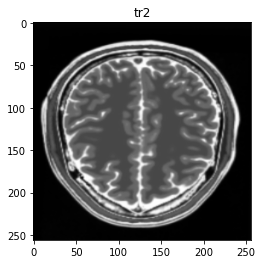

In [19]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [20]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [21]:
def unet_generator():
    inputs = tf.keras.layers.Input(shape=[None,None,OUTPUT_CHANNELS])
    down_stack = [
    downsample(64, 4, apply_norm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
    up_stack =  [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
generator_g = unet_generator() #initialise the generator

In [23]:
generator_f = unet_generator() #initialise the generator

In [24]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    #x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [25]:
discriminator_x = discriminator() #initialise the discriminator
#tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)


In [26]:
discriminator_y = discriminator() #initialise the discriminator
#tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

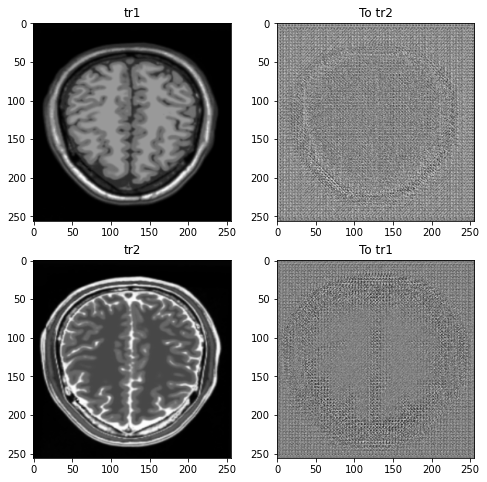

In [27]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [28]:
LAMBDA = 10

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real) #write your code here
    generated_loss =  loss_object(tf.zeros_like(generated), generated) #write your code here
    total_disc_loss = real_loss + generated_loss #write your code here
    return total_disc_loss * 0.5

In [31]:
def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

In [32]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image )) #write your code here
    return LAMBDA * loss1

In [33]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [34]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5,beta_2=0.999, epsilon=1e-06)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5,beta_2=0.999, epsilon=1e-06)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5,beta_2=0.999, epsilon=1e-06)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5,beta_2=0.999, epsilon=1e-06)

In [35]:
EPOCHS = 2000

In [36]:
checkpoint_path = r'StyleTransferGAN/'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [37]:
total_gen_loss_list = []
total_disc_loss_list = []

In [38]:
def generate_images(model, test_input,expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    g = generator_loss(prediction[0])
    d = discriminator_loss(test_input[0], prediction[0])
    total_gen_loss_list.append(g.numpy())
    total_disc_loss_list.append(d.numpy())
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [39]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        #gen_output = generator_g(real_x, training=True)
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y =generator_g(real_x)  #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y) #write your code to generate images using Generator_f on real_y
        cycled_y =generator_g(fake_x) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x)#write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y)#write your code to generate images using Generator_g on real_y
        
        disc_real_x =discriminator_x(real_x) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y)#write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x)#write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y)#write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)  # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) #write your code here #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)#write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)#write your code here
    discriminator_y_gradients =  tape.gradient(disc_y_loss, discriminator_y.trainable_variables)#write your code here
    
    # Apply the gradients to the optimizer
       
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    #write your code here
    #with summary_writer.as_default():
    #  tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch)
    #  tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=epoch)
    #  tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
    #  tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch)


In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    for image_x, image_y in tf.data.Dataset.zip((train_dataset, test_dataset)):
        train_step(image_x, image_y)
    capture_image_loss(generator_g, sample_tr1,sample_tr2)
    if (epoch + 1) % 500 == 0:
       ckpt_save_path = ckpt_manager.save()
       generate_images(generator_g, sample_tr1,sample_tr2)
       print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

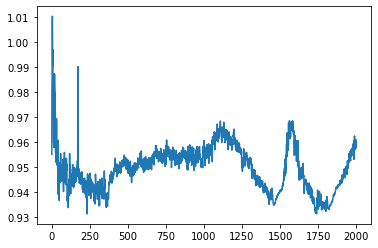

In [41]:
# Train lossess Generator
plt.plot(total_gen_loss_list)
plt.show()

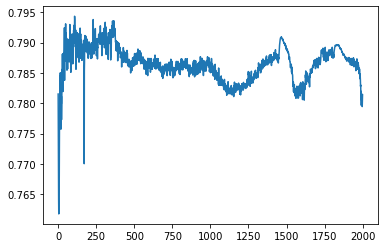

In [42]:
# Train lossess Discriminator
plt.plot(total_disc_loss_list)
plt.show()

In [43]:
total_gen_loss_list = []
total_disc_loss_list = []

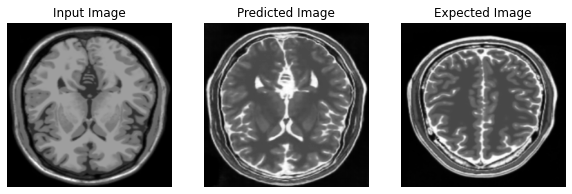

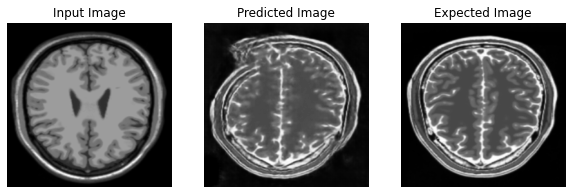

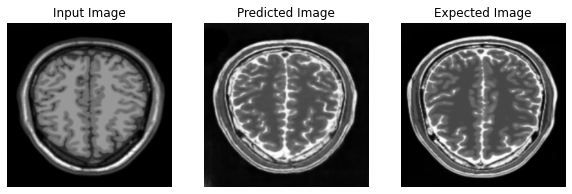

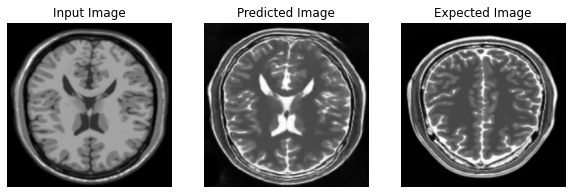

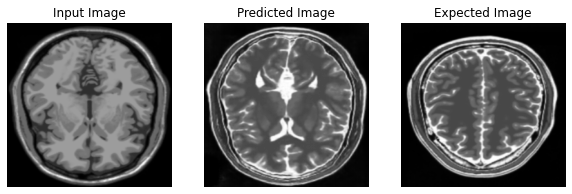

In [44]:
# Run the trained model on the test dataset
for inp in train_dataset.take(5):
    generate_images(generator_g, inp, sample_tr2)

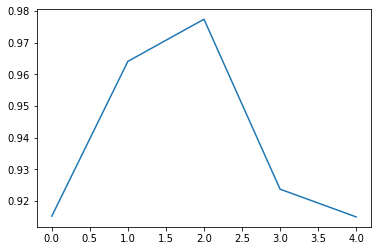

In [45]:
# Test lossess Generator
plt.plot(total_gen_loss_list)
plt.show()

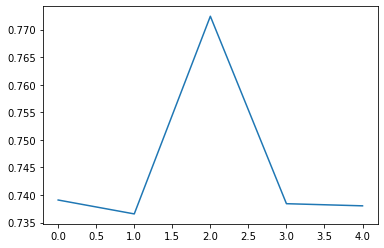

In [46]:
# Train lossess Discriminator
plt.plot(total_disc_loss_list)
plt.show()